In [1]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from scipy.integrate import odeint

#### Plot layout
sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette("Set1")
plt.rcParams["figure.dpi"] = 100
plt.rcParams['text.usetex'] = False

# 07 1D Heat transfer (implicit solution)

_notebook by Nico Liebers (nico.liebers@dlr.de), Deutsches Zentrum für Luft- und Raumfahrt (DLR), 2019_

> This notebook is strongly inspired by the notebooks of the online course _["Practical Numerical Methods with Python"](https://github.com/numerical-mooc/numerical-mooc/) by Lorena A. Barba et al_

In lesson 04 we developed the first finite difference solution for the onedimensional heat equation:

$$
\frac{T^{n+1}_{i} - T^n_{i}}{\triangle t} = \alpha_x \frac{T^n_{i-1} - 2 \cdot T^n_{i} + T^n_{i+1}}{\triangle x^2} + s^n_{i}
$$

Here the temperature of the next time step $T^{n+1}_{i}$ depends on three values of the present time step $T^{n}_{i-1}$, $T^{n}_{i}$ and $T^{n}_{i+1}$. 

Which is the forward or _explicit_ finite difference method. For this method the Courant-Friedrichs-Lewy (CFL) stability criterion had to be fulfilled to remain numerically stable:

$$
\sigma = \alpha \frac{\Delta t}{\Delta x^2} \leq \frac{1}{2}
$$

$$
 \Delta t  \leq \frac{\Delta x^2}{2 \alpha}
$$

This criterion can lead to very costly computations for larger and detailed models. 

## Implicit Formulation

A numerically _"unconditionally"_ stable scheme is the _implicit_ finite difference method. Here the spatial derivative is formulated depending on the next time step: 

$$
\frac{T_{i}^{n+1}-T_{i}^{n}}{\Delta t}=\alpha\frac{T_{i+1}^{n+1}-2T_{i}^{n+1}+T_{i-1}^{n+1}}{\Delta x^2}
$$

Which is an equation with three unknowns, which we bring to the left hand side and the known temperature to the right hand side:

$$
-T_{i-1}^{n+1} + \left( 2 + \frac{\Delta x^2}{\alpha\Delta t}\right) T_{i}^{n+1} - T_{i+1}^{n+1} = T_{i}^{n}\frac{\Delta x^2}{\alpha\Delta t}
$$

We substitute:

$$
\sigma = \frac{\alpha\Delta t}{\Delta x^2}
$$

$$
-T_{i-1}^{n+1} + \left( 2 + \frac{1}{\sigma} \right) T_{i}^{n+1} - T_{i+1}^{n+1} = T_{i}^{n} \frac{1}{\sigma}
$$

Taking the same example from lesson 04 we look at a small model of 5 elements with a fixed temperature on the left side and no heat flux in the right side:

<img src="./figures/heat 1d model 02.png" width="400"/>


We can formulate three of these equations, where we still have a total of two unknown temperatures:

$$
-T_{0}^{n+1} + \left( 2 + \frac{1}{\sigma} \right) T_{1}^{n+1} - T_{2}^{n+1} = T_{1}^{n} \frac{1}{\sigma}
$$

$$
-T_{1}^{n+1} + \left( 2 + \frac{1}{\sigma} \right) T_{2}^{n+1} - T_{3}^{n+1} = T_{2}^{n} \frac{1}{\sigma}
$$

$$
-T_{2}^{n+1} + \left( 2 + \frac{1}{\sigma} \right) T_{3}^{n+1} - T_{4}^{n+1} = T_{3}^{n} \frac{1}{\sigma}
$$

Putting in the boundary conditions:

$$
T_{0}^{n+1} = 100 ^\circ C
$$

$$
T_{4}^{n+1} = T_{3}^{n+1}
$$

We have __5 unknowns and 5 equations!__


We can put this system of equations into matrix form:

$$
[A][x] = [b]+[b]_{b.c.}
$$

With $[x]$ with the temperatures we want to calculate, $[b]$ the temperatures of the current time step and $[b]_{b.c.}$ the boundary conditions. Matrix $[A]$ specifies the relations between the tempertures in our model. 

$$
\begin{align}
    \left[
        \begin{array}{ccc}
            \left( 2 + \frac{1}{\sigma} \right) & -1 & 0  \\
            -1 & \left( 2 + \frac{1}{\sigma} \right) & -1  \\
             0 & -1 & \left( 1 + \frac{1}{\sigma} \right)
        \end{array}
    \right] \cdot 
    \left[
        \begin{array}{c} 
            T_1^{n+1} \\
            T_2^{n+1} \\           
            T_3^{n+1}
        \end{array}
    \right] =
    \left[
        \begin{array}{c} 
            T_1^n \frac{1}{\sigma} \\
            T_2^{n} \frac{1}{\sigma} \\
            T_3^{n} \frac{1}{\sigma}
        \end{array}
    \right] +
    \begin{bmatrix}
        100 ^\circ C \\
        0 \\
        0
    \end{bmatrix}
\end{align}
$$

We build again our model:

In [2]:
# explicit model
def explicit1D_nofluxright(T, sigma):
    T[1:-1] = (T[1:-1] +
               sigma * (T[2:] - 2 * T[1:-1] + T[:-2]))
    # no heat flux on right side
    T[-1] = T[-2]
    return T

In [3]:
from scipy import linalg
def calc_A_matrix(N, sigma):
    """
    Compute Matrix A for 1D model with dirichlet BC on left and 
    Neumann BC on right side
    """
    # Setup the diagonal of the operator.
    D = np.diag((2 + 1 / sigma) * np.ones(N))
    # Setup the Neumann condition for the last element.
    D[-1, -1] = 1 + 1 / sigma
    # Setup the upper diagonal of the operator.
    U = np.diag(-1 * np.ones(N - 1), k=1)
    # Setup the lower diagonal of the operator.
    L = np.diag(-1 * np.ones(N - 1), k=-1)
    # Assemble the operator.
    A = D + U + L
    return A
def calc_b_vector(T, sigma, udx=0):
    """
    Compute vector b + b_bc for 1D model with dirichlet BC on left and 
    Neumann BC (heat flux udx) on right side
    """
    b = T[1:-1] / sigma
    # Set Dirichlet condition.
    b[0] += T[0]
    # Set Neumann condition.
    b[-1] += udx
    return b
def implicit1D_nofluxright(T, sigma, A):
    """
    Solve implicit matrix formulation, pass matrix A (only calculate once)
    """
    # Generate the right-hand side of the system.
    b = calc_b_vector(T, sigma, 0)
    # Solve the system with scipy.linalg.solve.
    T[1:-1] = linalg.solve(A, b)
    # Apply the Neumann boundary condition.
    T[-1] = T[-2] 
    return T

In [4]:
d = 40 / 1000
Nx = 51
dx = d / (Nx - 1)
print("dx =", dx)
x = np.arange(Nx) * dx

alpha = 1e-5
dt_CLF = dx**2 / 2 / alpha
print("limit for numerical stability (explicit scheme): dt =", dt_CLF, "s")

# try larger and smaller time steps
dt_explicit = dt_CLF / 4

print("used time step (explicit scheme): dt =", dt_explicit, "s")

dt_factor = 2**8

dt_implicit = dt_explicit * dt_factor
print("used time step (implicit scheme): dt =", dt_implicit, "s")

print("dt_implicit / dt_explicit =", dt_factor)
print("dt_implicit / dt_CLF =", dt_implicit / dt_CLF)

T = np.zeros(Nx)
T[0] = 100

dx = 0.0008
limit for numerical stability (explicit scheme): dt = 0.032 s
used time step (explicit scheme): dt = 0.008 s
used time step (implicit scheme): dt = 2.048 s
dt_implicit / dt_explicit = 256
dt_implicit / dt_CLF = 64.0


<IPython.core.display.Javascript object>


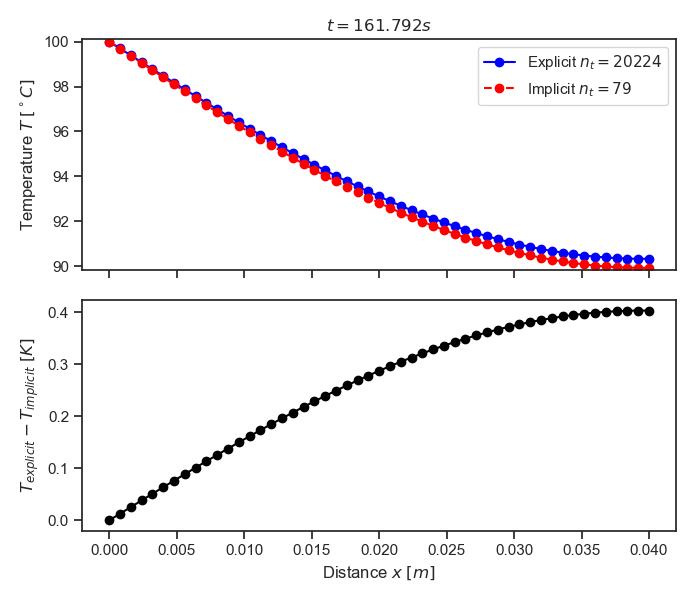

In [5]:
# number of time steps to compute
nt = 80  
# update plots after how many iterations
i_snap = 1

sigma_explicit = alpha * dt_explicit / dx**2
sigma_implicit = alpha * dt_implicit / dx**2

T1 = np.copy(T)
T2 = np.copy(T)
A = calc_A_matrix(Nx-2, sigma_implicit)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7.0, 6.0))
ax1, ax2 = ax
plt.ion()
for i in range(nt):        
    for ii in range(dt_factor):
        T1 = explicit1D_nofluxright(T1, sigma_explicit)
    T2 = implicit1D_nofluxright(T2, sigma_implicit, A)
    
    if i % i_snap == 0:
        plt.sca(ax1)
        plt.cla()
        plt.title(r"$t = %.3f s$" %(i*dt_implicit) )        
        plt.ylabel(r'Temperature $T \; [^\circ C]$')
        plt.plot(x, T1, "o-", color="b", 
                 label=r"Explicit $n_t = %d$" %(i*dt_factor))
        plt.plot(x, T2, "o--", color="r", 
                 label=r"Implicit $n_t = %d$" %(i))
        plt.legend()
        
        plt.sca(ax2)
        plt.cla()
        plt.ylabel(r'$T_{explicit} - T_{implicit} \; [K]$')
        plt.plot(x, T1-T2, "o-", color="k")
        plt.xlabel(r'Distance $x \; [m]$')
        
        ax1.set_ylim(
            (np.min([T1.min(), T2.min()])-.1,
             np.max([T1.max(), T2.max()])+.1)
                     )
        
        #[_ax.relim() for _ax in ax]
        #[_ax.autoscale(tight=True) for _ax in ax]
        plt.tight_layout()
        fig.canvas.flush_events()
        fig.canvas.draw()    
        plt.pause(.2);